Load data

In [1]:
import json

with open("paragraphs_weights_dataset.json", "r") as read_file:
    raw_data = json.load(read_file)

Some helper functions

In [2]:
# Culminative weights
def c_weights(weights):
    res = [weights[0]]
    for w in weights[1:]:
        res.append(res[-1] + w)
    return res

# Locations of center of each paragraph
def p_centers(weights):
    c_weights = weights[0]
    res = [weights[0]/2.0]
    for w in weights[1:]:
        res.append(c_weights + w/2.0)
        c_weights += w
    return res

# Weights of paragraphs after merges are applied 
def res_weights(weights, merge_idx):
    res = [weights[0]]
    for idx,w in enumerate(weights[1:]):
        i = idx + 1
        if i in merge_idx:
            res[-1] += w
        else:
            res.append(w)
    return res

# Resulting culminative weights after merges are applied
def res_c_weights(c_weights, merge_idx):
    return [c_w for i, c_w in enumerate(c_weights) if (i+1) not in merge_idx]

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,5)

# Display matching between paragraph weights
def visualize_weights(cws1, cws2):
    plt.subplot(131)
    plt.plot(cws1, 'ro')
    plt.plot(cws2, 'bx')

    plt.ylabel('Paragraph weight')
    plt.xlabel('Paragraph num')
    plt.subplot(132)
    plt.plot(c_weights(cws1), 'ro')
    plt.plot(c_weights(cws2), 'bx')

    plt.ylabel('Paragraph cumulative weight')
    plt.xlabel('Paragraph num')
    
    plt.subplot(133)
    plt.plot(p_centers(cws1), cws1, 'ro')
    plt.plot(p_centers(cws2), cws2, 'bx')

    plt.ylabel('Paragraph weight')
    plt.xlabel('Paragraph coordinate')

    plt.show()

Without any matching

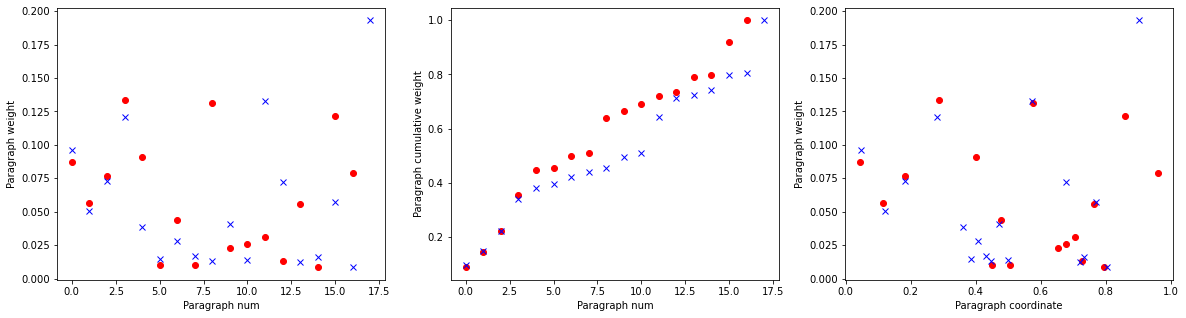

In [4]:
ch = raw_data[0]['chapters'][1]
visualize_weights(
    ch['source_weights'],
    ch['target_weights']
)

Correct merge of the same chapter

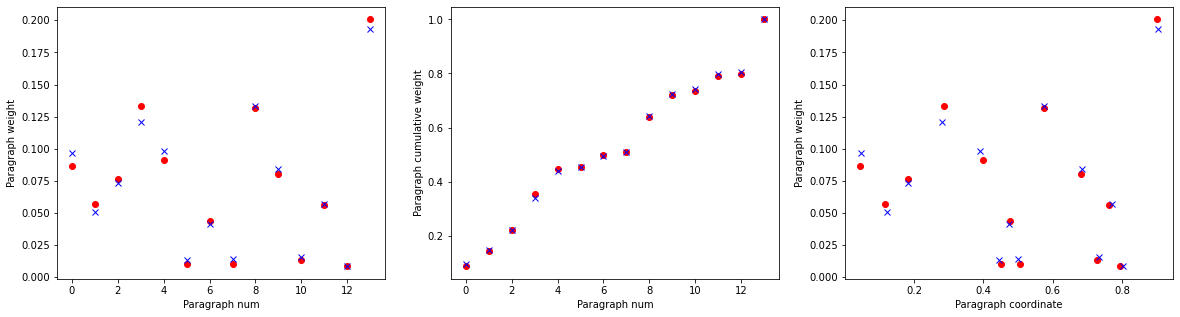

In [5]:
visualize_weights(
    res_weights(ch['source_weights'],ch['merged_source_idx']),
    res_weights(ch['target_weights'],ch['merged_target_idx'])
)

Basic class to find paragraphs, that should be merged

In [6]:
def visualize_merges(cws1, cws2, t=None):
    plt.subplot(121)
    plt.plot(cws1, 'ro')
    plt.plot(cws2, 'bx')

    plt.ylabel('Paragraph weight')
    plt.xlabel('Paragraph num')
    plt.subplot(122)
    plt.plot(c_weights(cws1), 'ro')
    plt.plot(c_weights(cws2), 'bx')

    plt.ylabel('Paragraph cumulative weight')
    plt.xlabel('Paragraph num')
    if t:
        plt.title = t
    plt.show()

class ChapterResolverBase(object):
    def __init__(self, chapter):
        self.source_weights = chapter['source_weights']
        self.target_weights = chapter['target_weights']
        self.merged_source_idx = set()
        self.merged_target_idx = set()
        self.source_mapping = list(range(len(self.source_weights)))
        self.target_mapping = list(range(len(self.target_weights)))
        self.current_source_weights = self.source_weights.copy()
        self.current_target_weights = self.target_weights.copy()
        self.current_c_source_weights = c_weights(self.source_weights)
        self.current_c_target_weights = c_weights(self.target_weights)
        self.correct_merged_source_idx = chapter['merged_source_idx']
        self.correct_merged_target_idx = chapter['merged_target_idx']
    
    def add_merge_points(self, si, ti):
        if si:
            self.merged_source_idx.add(si)
            for i in range(si, len(self.source_mapping)):
                self.source_mapping[i] -= 1
            self.current_source_weights = res_weights(self.source_weights, self.merged_source_idx)
            self.current_c_source_weights = c_weights(self.current_source_weights)
        if ti:
            self.merged_target_idx.add(ti)
            for i in range(ti, len(self.target_mapping)):
                self.target_mapping[i] -= 1
            self.current_target_weights = res_weights(self.target_weights, self.merged_target_idx)
            self.current_c_target_weights = c_weights(self.current_target_weights)
            
    def plot(self, plot_correct_result=False):
        if plot_correct_result:
            visualize_merges(
                res_weights(self.source_weights, self.correct_merged_source_idx),
                res_weights(self.target_weights, self.correct_merged_target_idx),
                'Correct zip'
            )
        else:
            visualize_merges(
                self.current_source_weights, self.current_target_weights,
                "Current zip")

        
    def source_target_merge_weights(self):
        return self.result()
    
    def result(self):
        msi = list(self.merged_source_idx)
        msi.sort()
        mti = list(self.merged_target_idx)
        mti.sort()      
        return {
            'merged_source_idx': msi,
            'merged_target_idx': mti
        } 
 

Very simple resolver used as baseline

In [7]:
class ChapterResolverPorted(ChapterResolverBase):
    def get_source_merge_weights(self, loc_source, loc_target):
        # assuming len(loc_source) >= len(loc_target)
        # output: [index of paragraphs thet should be attached to previous source]
        last_target_pos = 0
        target_source_diff = len(loc_source) - len(loc_target)
        res = []
        for i, loc in enumerate(loc_source[1:]):
            source_pos = i + 1
            if target_source_diff == 0:    
                return res
            elif (last_target_pos == len(loc_target) - 1):
                res.append(source_pos)
            else:
                dist_to_t0 = abs(loc - loc_target[last_target_pos])
                dist_to_t1 = abs(loc - loc_target[last_target_pos+1])
                if dist_to_t0 < dist_to_t1:
                    res.append(source_pos)
                    target_source_diff -= 1
                else:
                    last_target_pos += 1
        return res
        
    def source_target_merge_weights(self):
        swap_source_target = len(self.source_weights) < len(self.target_weights)
        source_locs = p_centers(self.source_weights)
        target_locs = p_centers(self.target_weights)
        if swap_source_target:
            return {
                'merged_source_idx': [],
                'merged_target_idx': self.get_source_merge_weights(target_locs, source_locs)
            }
        else:
            return {
                'merged_target_idx': [],
                'merged_source_idx': self.get_source_merge_weights(source_locs, target_locs)
            }       

And how will it perform on the same chapter

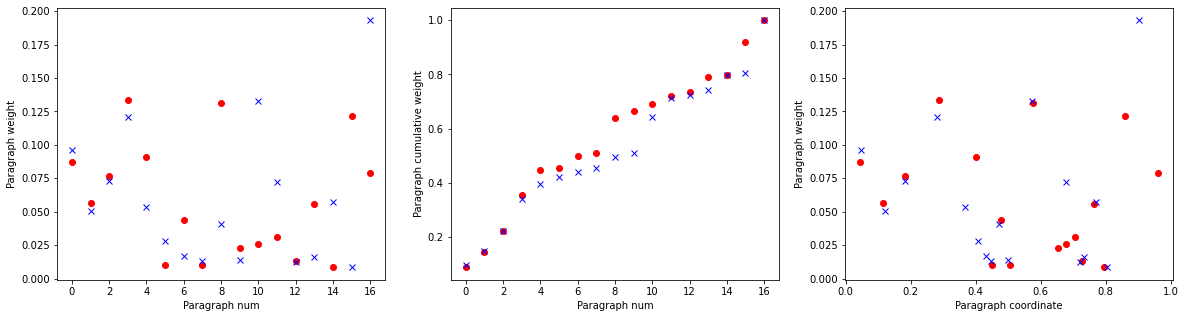

In [8]:
r = ChapterResolverPorted(ch).source_target_merge_weights()
visualize_weights(
    res_weights(ch['source_weights'], r['merged_source_idx']),
    res_weights(ch['target_weights'], r['merged_target_idx'])
)

not a very good performance

Some methods to evaluate resolvers

In [9]:
def get_chapter_metrics(chapter, resolver, **extra_params):
    resolved = resolver(chapter, **extra_params).source_target_merge_weights()
    resolved_msi = set(resolved['merged_source_idx'])
    resolved_mti = set(resolved['merged_target_idx'])
    true_msi = set(chapter['merged_source_idx'])
    true_mti = set(chapter['merged_target_idx'])
    # -1 because first paragraph can't be merged
    len_source = len(chapter['source_weights']) - 1
    len_target = len(chapter['target_weights']) - 1
    tp_cnt = len(resolved_msi & true_msi) + len(resolved_mti & true_mti)
    fp_cnt = len(resolved_msi - true_msi) + len(resolved_mti - true_mti)
    fn_cnt = len(true_msi- resolved_msi) + len(true_mti - resolved_mti)
    tn_cnt = len_source + len_target - tp_cnt - fp_cnt - fn_cnt
    return {
        'tp': tp_cnt,
        'tn': tn_cnt,
        'fp': fp_cnt,
        'fn': fn_cnt,
        'total': len_source + len_target
    }
    

def get_agg_metrics(books, resolver, **extra_params):
    res = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0, 'total': 0}
    for b in books:
        for c in b['chapters']:
            cm = get_chapter_metrics(c, resolver, **extra_params)
            for (k,v) in cm.items():
                res[k] += v
    return res

def get_norms(books, resolver, **extra_params):
    counts = get_agg_metrics(books, resolver, **extra_params)
    precision =  float(counts['tp']) / (counts['tp'] + counts['fp'] + 0.0001) #tp / tp + fp
    recall = float(counts['tp']) / (counts['tp'] + counts['fn'] + 0.0001)
    return {
        'accuracy': (counts['tp']+counts['tn'])/float(counts['total']),
        'precision': precision,
        'recall': recall,
        'f1': 2 * precision * recall / (precision + recall + 0.000001)
    }

Baseline score for baseline resolver:

In [10]:
get_norms(raw_data, ChapterResolverPorted)

{'accuracy': 0.9506172839506173,
 'precision': 0.36841911358361273,
 'recall': 0.17948671926482238,
 'f1': 0.2413780374586744}

A better resolver

In [11]:
import numpy as np

class ChapterResolverCWeights(ChapterResolverBase):
    def __init__(self, chapter, max_weight_coef = 2.0, allow_p_merge=True, weight_coef=1.0):
        super(ChapterResolverCWeights, self).__init__(chapter)
        self.max_weight = np.mean(self.source_weights + self.target_weights) * max_weight_coef
        self.allow_p_merge = allow_p_merge
        self.weight_coef = weight_coef
        self.distance = self.distance_with_merged_idx(None, None)

        
    def allowed_pair_merge(self, si, ti):
        if not self.allow_p_merge:
            return False
        not_in_same_paragraph = self.source_mapping[si] != self.target_mapping[ti]
        mapped_source_i = self.source_mapping[si]
        mapped_target_i = self.target_mapping[ti]
        res_source_p_weight = sum(self.current_source_weights[mapped_source_i-1:mapped_source_i+1])
        res_target_p_weight = sum(self.current_source_weights[mapped_target_i-1:mapped_target_i+1])
        allowed_weight = max(res_source_p_weight, res_target_p_weight) < self.max_weight
        return (not_in_same_paragraph and allowed_weight)
        
    def best_distance_and_merge(self):
        best_dist = self.distance
        best_merge = (None, None)
        for si in range(1, len(self.source_weights)):
            if si not in self.merged_source_idx:
                # new_dist = self.distance_with_merged_idx(
                #     self.merged_source_idx | {si},
                #     self.merged_target_idx
                # )
                new_dist = self.distance_with_merged_idx(si, None)
                if new_dist < best_dist:
                    best_dist = new_dist
                    best_merge = (si, None)
                for ti in range(1, len(self.target_weights)):
                    if (ti not in self.merged_target_idx) and (self.allowed_pair_merge(si,ti)):
                        new_dist = self.distance_with_merged_idx(si, ti)
                        if new_dist < best_dist:
                            best_dist = new_dist
                            best_merge = (si, ti)     
        for ti in range(1, len(self.target_weights)):
            if ti not in self.merged_target_idx:
                new_dist = self.distance_with_merged_idx(None, ti)
                if new_dist < best_dist:
                    best_dist = new_dist
                    best_merge = (None, ti)
        if best_merge == (None, None):
            return None
        else:
            return (best_dist, best_merge)

    def source_target_merge_weights(self, debug=False):
        m_a_d = self.best_distance_and_merge()
        while m_a_d:
            self.distance, (si, ti) = m_a_d
            self.add_merge_points(si, ti)
            if debug:
                print(m_a_d)
                add_merge_points(self, si, ti)
                self.plot()
            m_a_d = self.best_distance_and_merge()
        return self.result()
    
    def distance_with_merged_idx(self, si, ti):
        if si:
            si_mapped = self.source_mapping[si]
            current_c_s_weights = self.current_c_source_weights[:si_mapped-1] + self.current_c_source_weights[si_mapped:]
            new_weight = sum(self.current_source_weights[si_mapped-1:si_mapped+1])
            current_s_weights = self.current_source_weights[:si_mapped-1] + [new_weight] + self.current_source_weights[si_mapped+1:]
        else:
            current_c_s_weights = self.current_c_source_weights
            current_s_weights = self.current_source_weights
        if ti:
            ti_mapped = self.target_mapping[ti]
            current_c_t_weights = self.current_c_target_weights[:ti_mapped-1] + self.current_c_target_weights[ti_mapped:]
            new_weight = sum(self.current_target_weights[ti_mapped-1:ti_mapped+1])
            current_t_weights = self.current_target_weights[:ti_mapped-1] + [new_weight] + self.current_target_weights[ti_mapped+1:]
        else:
            current_c_t_weights = self.current_c_target_weights
            current_t_weights = self.current_target_weights


        # current_t_c_weights = res_c_weights(self.target_c_weights, mti)
        loc_distance = np.mean([
            abs(sw-tw) for sw, tw in
            zip(current_c_s_weights, current_c_t_weights)
        ])
        weight_distance = np.mean([
            abs(sw-tw) for sw, tw in
            zip(current_s_weights, current_t_weights)
        ])
        return (loc_distance + self.weight_coef * weight_distance)

Let's see how it performs

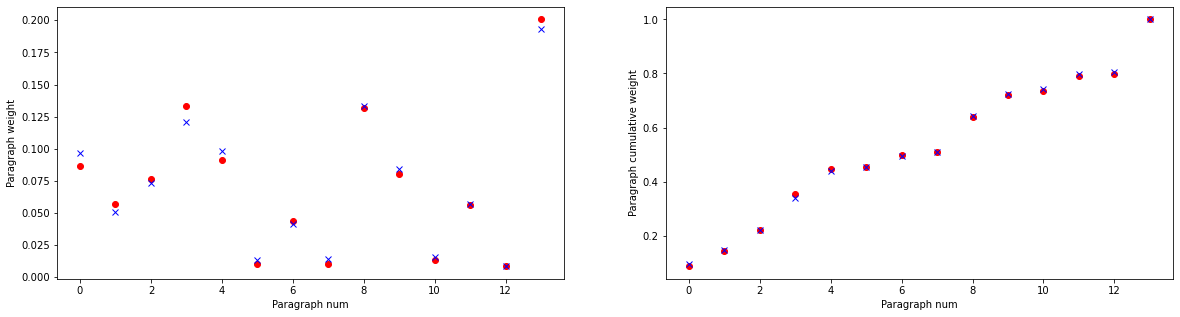

{'tp': 3, 'tn': 22, 'fp': 4, 'fn': 4, 'total': 33}

In [12]:
ch = raw_data[0]['chapters'][1]
# visualize_weights(
#     res_weights(ch['source_weights'], ch['merged_source_idx']),
#     res_weights(ch['target_weights'], ch['merged_target_idx'])
# )
rs = ChapterResolverCWeights(ch, max_weight_coef=1.0, weight_coef=3.5)
r = rs.source_target_merge_weights()
rs.plot(True)
get_chapter_metrics(ch, ChapterResolverCWeights, allow_p_merge=True, weight_coef=3.5, max_weight_coef=1.0)

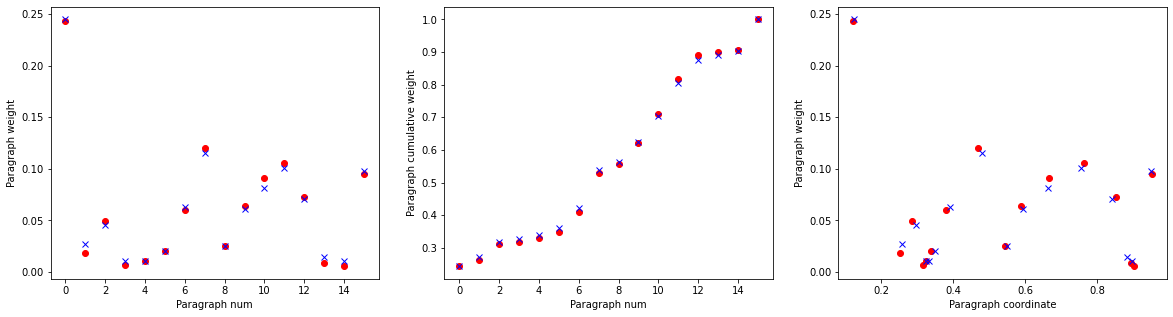

In [13]:
ch = raw_data[0]['chapters'][3]
r = ChapterResolverCWeights(ch, max_weight_coef=1.0, weight_coef=3.5).source_target_merge_weights()
visualize_weights(
    res_weights(ch['source_weights'], r['merged_source_idx']),
    res_weights(ch['target_weights'], r['merged_target_idx'])
)

In [14]:
get_norms(raw_data, ChapterResolverCWeights, allow_p_merge=False)

{'accuracy': 0.9663299663299664,
 'precision': 0.6551701545856738,
 'recall': 0.48717823800451787,
 'f1': 0.5588213966314963}

In [15]:
get_norms(raw_data, ChapterResolverCWeights, allow_p_merge=True, weight_coef=4.0)

{'accuracy': 0.9450056116722784,
 'precision': 0.42187434082134245,
 'recall': 0.6923059171643149,
 'f1': 0.524270356115019}

In [16]:
for w_c in range(1,6):
    # m_w_c = 1 + w_c * 0.4
    m_w_c = 0.5
    print((2.5 + 0.3 * w_c))
    print(get_norms(raw_data, ChapterResolverCWeights, allow_p_merge=True, max_weight_coef=m_w_c, weight_coef=(2.5 + 0.3 * w_c)))

2.8
{'accuracy': 0.9685746352413019, 'precision': 0.703701097403343, 'recall': 0.48717823800451787, 'f1': 0.5757553475721677}
3.1
{'accuracy': 0.9685746352413019, 'precision': 0.703701097403343, 'recall': 0.48717823800451787, 'f1': 0.5757553475721677}
3.4
{'accuracy': 0.9708193041526375, 'precision': 0.7241354340157448, 'recall': 0.5384601577944671, 'f1': 0.6176447530333484}
3.7
{'accuracy': 0.9708193041526375, 'precision': 0.7241354340157448, 'recall': 0.5384601577944671, 'f1': 0.6176447530333484}
4.0
{'accuracy': 0.9696969696969697, 'precision': 0.6999976666744444, 'recall': 0.5384601577944671, 'f1': 0.6086933963507671}


This one looks like a good candidate

In [17]:
get_norms(raw_data, ChapterResolverCWeights, allow_p_merge=True, weight_coef=3.5, max_weight_coef=0.5)

{'accuracy': 0.9708193041526375,
 'precision': 0.7241354340157448,
 'recall': 0.5384601577944671,
 'f1': 0.6176447530333484}

In [18]:
class ChapterResolverZipper(ChapterResolverBase):
    def __init__(self, chapter):
        super(ChapterResolverZipper, self).__init__(chapter)
        self.res_pointer = 0
        self.s_pointer = 1
        self.t_pointer = 1
    
    def merge_source(self):
        self.add_merge_points(self.s_pointer, None)
        self.s_pointer += 1
        
    def merge_target(self):
        self.add_merge_points(None, self.t_pointer)
        self.t_pointer += 1
    
    def no_merge(self):
        self.t_pointer += 1
        self.s_pointer += 1
        self.res_pointer += 1
        
    def weights_after_merge(self, si, ti):
        if si and (si < len(self.source_weights)):
            si_mapped = self.source_mapping[si]
            new_c_s_weights = self.current_c_source_weights[:si_mapped-1] + self.current_c_source_weights[si_mapped:]
            new_weight = sum(self.current_source_weights[si_mapped-1:si_mapped+1])
            new_s_weights = self.current_source_weights[:si_mapped-1] + [new_weight] + self.current_source_weights[si_mapped+1:]
        else:
            new_c_s_weights = self.current_c_source_weights
            new_s_weights = self.current_source_weights
        if ti and (ti < len(self.target_weights)):
            ti_mapped = self.target_mapping[ti]
            new_c_t_weights = self.current_c_target_weights[:ti_mapped-1] + self.current_c_target_weights[ti_mapped:]
            new_weight = sum(self.current_target_weights[ti_mapped-1:ti_mapped+1])
            new_t_weights = self.current_target_weights[:ti_mapped-1] + [new_weight] + self.current_target_weights[ti_mapped+1:]
        else:
            new_c_t_weights = self.current_c_target_weights
            new_t_weights = self.current_target_weights
        return {
            'new_c_s': new_c_s_weights,
            'new_c_t': new_c_t_weights,
            'new_s_w': new_s_weights,
            'new_t_w': new_t_weights
        }
    
    def metrics(self, s_ws, t_ws, c_s_ws, c_t_ws):
        s_ws_r = s_ws[self.res_pointer+1:self.res_pointer+5]
        t_ws_r = t_ws[self.res_pointer+1:self.res_pointer+5]
        if s_ws_r == []:
            s_ws_r = [1.0e-8]
        if t_ws_r == []:
            t_ws_r = [1.0e-8]
        if len(s_ws_r) < len(t_ws_r):
            t_ws_r[len(s_ws_r)-1:] = [sum(t_ws_r[len(s_ws_r)-1:])]
        if len(t_ws_r) < len(s_ws_r):
            s_ws_r[len(t_ws_r)-1:] = [sum(s_ws_r[len(t_ws_r)-1:])]
        w_distance = abs(np.log(
            s_ws[self.res_pointer] / t_ws[self.res_pointer]
        ))
        w_distance_after= np.mean([
            abs(np.log(sw/tw)) for sw, tw in
            zip( s_ws_r, t_ws_r)
        ])
        c_distance_after = np.mean([
            abs(sw-tw) for sw, tw in
            zip(
                c_s_ws[self.res_pointer:self.res_pointer+6],
                c_t_ws[self.res_pointer:self.res_pointer+6]
            )
        ])
        return (w_distance, w_distance_after, c_distance_after)
    
    def distances_summary(self):
        weights_s_m = self.weights_after_merge(self.s_pointer, None)
        weights_t_m = self.weights_after_merge(None, self.t_pointer)
        print(
            'No merge:     ',
            self.metrics(self.current_source_weights, self.current_target_weights,
                         self.current_c_source_weights, self.current_c_target_weights
                   )
             )
        if (self.s_pointer < len(self.source_weights)):
            print(
                'Merged source:',
                self.metrics(weights_s_m['new_s_w'], weights_s_m['new_t_w'],
                             weights_s_m['new_c_s'], weights_s_m['new_c_t']
                            )
            )
        if (self.t_pointer < len(self.target_weights)):
            print(
                'Merged target:',
                self.metrics(weights_t_m['new_s_w'], weights_t_m['new_t_w'],
                             weights_t_m['new_c_s'], weights_t_m['new_c_t']
                            )
            )



In [19]:
ch = raw_data[0]['chapters'][1]
zipper = ChapterResolverZipper(ch)

No merge:      (0.10556526263852373, 0.2823881631473305, 0.02544654156889839)
Merged source: (0.39851497298793526, 0.6559417584733747, 0.08984236221801123)
Merged target: (0.527082079757196, 0.9393727888509453, 0.06107888273965481)


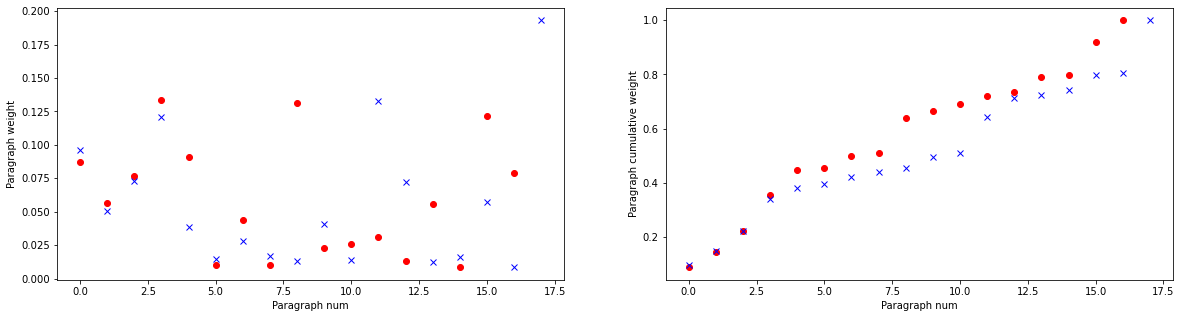

0

In [20]:
# zipper.no_merge()
# zipper.merge_target()
# zipper.merge_source()
zipper.distances_summary()
zipper.plot(); zipper.res_pointer

Next step - determine type of merge in zipper using simple ML

Dataset creation:

In [21]:
class ChapterDataBuilderV2(ChapterResolverZipper):
    
    def __init__(self, chapter):
        super(ChapterDataBuilderV2, self).__init__(chapter)
        self.cols = ['chapter_title',
                     'weight_dist_par', 'weight_dist_next', 'c_weight_dist_next',
                     'weight_dist_par_after_s_merge', 'weight_dist_next_after_s_merge','c_weight_dist_next_after_s_merge',
                     'merged_source']

    
    def build_next_vals(self):
        # return possibly multiple records
        if (self.s_pointer == len(self.source_weights)) or (self.t_pointer == len(self.target_weights)):
            return None
        weights_s_m = self.weights_after_merge(self.s_pointer, None)
        weights_t_m = self.weights_after_merge(None, self.t_pointer)
        (w_distance, w_distance_after, c_distance_after) = self.metrics(
            self.current_source_weights, self.current_target_weights,
            self.current_c_source_weights, self.current_c_target_weights
        )
        metrics_s_m = self.metrics(
            weights_s_m['new_s_w'], weights_s_m['new_t_w'],
            weights_s_m['new_c_s'], weights_s_m['new_c_t']
        )
        metrics_t_m = self.metrics(
            weights_t_m['new_s_w'], weights_t_m['new_t_w'],
            weights_t_m['new_c_s'], weights_t_m['new_c_t']
        )
        res_base = {
            'weight_dist_par': w_distance,
            'weight_dist_next': w_distance_after,
            'c_weight_dist_next': c_distance_after,
            'weight_dist_par_after_s_merge': metrics_s_m[0],
            'weight_dist_next_after_s_merge': metrics_s_m[1],
            'c_weight_dist_next_after_s_merge': metrics_s_m[2],
            'merged_source': self.s_pointer in self.correct_merged_source_idx
        }
        res_base_mirrored = {
            'weight_dist_par': w_distance,
            'weight_dist_next': w_distance_after,
            'c_weight_dist_next': c_distance_after,
            'weight_dist_par_after_s_merge': metrics_t_m[0],
            'weight_dist_next_after_s_merge': metrics_t_m[1],
            'c_weight_dist_next_after_s_merge': metrics_t_m[2],
            'merged_source': self.t_pointer in self.correct_merged_target_idx
        }
        if (self.s_pointer in self.merged_source_idx) and (self.t_pointer in self.merged_target_idx):
            if weights_s_m[0] < weights_t_m[0]:
                res_base_mirrored['merged_source'] =  False
                self.merge_source()
            else:
                res_base['merged_source'] =  False
                self.merge_target()
        elif self.s_pointer in self.correct_merged_source_idx:
            self.merge_source()
        elif self.t_pointer in self.correct_merged_target_idx:
            self.merge_target()
        else:
            self.no_merge()
        return [res_base, res_base_mirrored]

In [22]:
import pandas as pd

def build_weights_df(raw_data):
    book_dfs = []
    for b in raw_data:
        book_title = b['title'].strip()
        chapter_dfs = []
        for c in b['chapters']:
            chapter_title = c['title'].strip()
            cdb = ChapterDataBuilderV2(c)
            res_dict = {}
            res_rows = cdb.build_next_vals()
            #print(res_rows[0])
            for k, v in res_rows[0].items():
                res_dict[k] = [v]
            res_rows = res_rows[1:]
            while not(res_rows is None):
                for r in res_rows:
                    for k, v in r.items():
                        res_dict[k].append(v)
                res_rows = cdb.build_next_vals()
            chapter_df = pd.DataFrame(data=res_dict)
            chapter_df['Chapter title'] = chapter_title
            chapter_dfs.append(chapter_df)
        book_df = pd.concat(chapter_dfs, ignore_index=True)
        book_df['Book title'] = book_title
        book_dfs.append(book_df)
    return pd.concat(book_dfs, ignore_index=True)

In [23]:
weights_data = build_weights_df(raw_data)
weights_data

,weight_dist_par,weight_dist_next,c_weight_dist_next,weight_dist_par_after_s_merge,weight_dist_next_after_s_merge,c_weight_dist_next_after_s_merge,merged_source,Chapter title,Book title
0,0.173673,0.469478,0.009501,0.472955,0.821493,0.018803,False,CHAPTER I\n - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./I.,Война и мир en - Война и мир
1,0.173673,0.469478,0.009501,0.688982,0.608242,0.031249,False,CHAPTER I\n - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./I.,Война и мир en - Война и мир
2,0.125309,0.441790,0.008529,0.338402,0.534017,0.016456,True,CHAPTER I\n - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./I.,Война и мир en - Война и мир
3,0.125309,0.441790,0.008529,0.443785,0.539574,0.025763,False,CHAPTER I\n - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./I.,Война и мир en - Война и мир
4,0.338402,0.534017,0.016456,0.677756,0.415889,0.037485,False,CHAPTER I\n - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./I.,Война и мир en - Война и мир
...,...,...,...,...,...,...,...,...,...
917,0.062756,0.104544,0.013320,0.977360,0.939252,0.064105,False,Erster Teil/XI - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./VIII.,Война и мир de - Война и мир
918,0.025951,0.143841,0.013734,0.052350,0.403334,0.037173,False,Erster Teil/XI - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./VIII.,Война и мир de - Война и мир
919,0.025951,0.143841,0.013734,0.126330,0.297758,0.011154,False,Erster Teil/XI - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./VIII.,Война и мир de - Война и мир
920,0.285551,0.002131,0.017571,1.013732,15.417622,0.049635,False,Erster Teil/XI - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./VIII.,Война и мир de - Война и мир


In [24]:
chapter_titles = weights_data['Chapter title'].unique()#[[1,2]]
chapter_titles

array(['CHAPTER I\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./I.',
       'CHAPTER II\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./II.',
       'CHAPTER III\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./III.',
       'CHAPTER IV\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./III.',
       'CHAPTER IV\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./IV.',
       'CHAPTER V\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./IV.',
       'CHAPTER VI\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./V.',
       'CHAPTER VII\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./VI.',
       'CHAPTER XXVIII\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./XXV.',
       'Erster Teil/I - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./I.',
       'Erster Teil/II - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./II.',
       'Erster Teil/III - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./III.',
       'Erster Teil/XI - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./VIII.'], dtype=object)

In [25]:
kv_excl_chapter_dx = [[0,9],[1,10],[2,11], [7,12]]
kv_excl_chapter_names = [[chapter_titles[ci] for ci in ixs] for ixs in kv_excl_chapter_dx]
kv_excl_chapter_names

[['CHAPTER I\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./I.',
  'Erster Teil/I - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./I.'],
 ['CHAPTER II\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./II.',
  'Erster Teil/II - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./II.'],
 ['CHAPTER III\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./III.',
  'Erster Teil/III - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./III.'],
 ['CHAPTER VII\n     - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./VI.',
  'Erster Teil/XI - ТОМ ПЕРВЫЙ/ЧАСТЬ ПЕРВАЯ./VIII.']]

In [26]:
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import LogisticRegression

lin_pred = []
svm_pred = []
xgb_pred = []
lin_pred_test = []
svm_pred_test = []
xgb_pred_test = []
y_true = []
y_true_test = []

x_cols = ['weight_dist_par', 'weight_dist_next', 'c_weight_dist_next',
       'weight_dist_par_after_s_merge', 'weight_dist_next_after_s_merge',
       'c_weight_dist_next_after_s_merge'
         ]
y_col = 'merged_source'

for excl_chapter_names in kv_excl_chapter_names:
    train_idx = weights_data['Chapter title'].apply(lambda ct: ct not in excl_chapter_names)
    test_idx = weights_data['Chapter title'].apply(lambda ct: ct in excl_chapter_names)
    X_train = weights_data[x_cols][train_idx]
    y_train = weights_data[y_col][train_idx].astype(int)
    X_test = weights_data[x_cols][test_idx]
    y_test = weights_data[y_col][test_idx].astype(int)
    
    # numeric_pipeline = Pipeline(
    #     steps=[("scale", StandardScaler())]
    # )


    num_cols = X_train.columns
    # full_processor = ColumnTransformer(
    #     transformers=[
    #         ("numeric", numeric_pipeline, x_cols),
    #     ]
    # )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    xgb_cl = xgb.XGBClassifier(n_estimators=8, use_label_encoder=False)
    svm_cl = svm.SVC()
    lin_cl = LogisticRegression()
    
    xgb_cl.fit(X_train_scaled, y_train.astype(int))
    svm_cl.fit(X_train_scaled, y_train.astype(int))
    lin_cl.fit(X_train_scaled, y_train.astype(int))
    
    xgb_pred.append(xgb_cl.predict(X_train_scaled))
    xgb_pred_test.append(xgb_cl.predict(X_test_scaled))
    
    svm_pred.append(svm_cl.predict(X_train_scaled))
    svm_pred_test.append(svm_cl.predict(X_test_scaled))
    
    lin_pred.append(lin_cl.predict(X_train_scaled))
    lin_pred_test.append(lin_cl.predict(X_test_scaled))
    
    y_true.append(y_train)
    y_true_test.append(y_test)
    

[20:21:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:01] WARNING: /tmp/abs_40obctay9q/croots/recip

And here are the results

In [27]:
y_true = np.concatenate(y_true)
y_true_test = np.concatenate(y_true_test)
print('F1 scores lin clf:')
print(f1_score(np.concatenate(lin_pred), y_true), f1_score(np.concatenate(lin_pred_test), y_true_test))
print('F1 scores svm clf:')
print(f1_score(np.concatenate(svm_pred), y_true), f1_score(np.concatenate(svm_pred_test), y_true_test))
print('F1 scores xgb clf:')
print(f1_score(np.concatenate(xgb_pred), y_true), f1_score(np.concatenate(xgb_pred_test), y_true_test))

F1 scores lin clf:
0.7536231884057972 0.6829268292682927
F1 scores svm clf:
0.7253886010362695 0.3870967741935484
F1 scores xgb clf:
0.927038626609442 0.6842105263157895


Looks like linear classifier is good enough. Let's train it on the whole dataset

In [28]:
X_train = weights_data[x_cols]
y_train = weights_data[y_col].astype(int)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
lin_cl = LogisticRegression()
lin_cl.fit(X_train_scaled, y_train)
f1_score(lin_cl.predict(X_train_scaled), y_train)

0.7419354838709677

Now let's update Zipper so that it will use this classifier

In [29]:
class ChapterResolverZipperLR(ChapterResolverZipper):
    def __init__(self, chapter, scaler, clf):
        super(ChapterResolverZipperLR, self).__init__(chapter)
        self.scaler = scaler
        self.clf = clf
    
    def next_merge(self):
        if (self.s_pointer == len(self.source_weights)) and (self.t_pointer == len(self.target_weights)):
            return None
        elif (self.s_pointer == len(self.source_weights)) and (self.t_pointer < len(self.target_weights)):
            return 'T'
        elif (self.s_pointer < len(self.source_weights)) and (self.t_pointer == len(self.target_weights)):
            return 'S'
        else:
            weights_s_m = self.weights_after_merge(self.s_pointer, None)
            weights_t_m = self.weights_after_merge(None, self.t_pointer)
            (w_distance, w_distance_after, c_distance_after) = self.metrics(
                self.current_source_weights, self.current_target_weights,
                self.current_c_source_weights, self.current_c_target_weights
            )
            metrics_s_m = self.metrics(
                weights_s_m['new_s_w'], weights_s_m['new_t_w'],
                weights_s_m['new_c_s'], weights_s_m['new_c_t']
            )
            metrics_t_m = self.metrics(
                weights_t_m['new_s_w'], weights_t_m['new_t_w'],
                weights_t_m['new_c_s'], weights_t_m['new_c_t']
            )
            X = pd.DataFrame(data={
                'weight_dist_par': [w_distance, w_distance],
                'weight_dist_next': [w_distance_after, w_distance_after],
                'c_weight_dist_next': [c_distance_after, c_distance_after],
                'weight_dist_par_after_s_merge': [metrics_s_m[0], metrics_t_m[0]],
                'weight_dist_next_after_s_merge': [metrics_s_m[1], metrics_t_m[1]],
                'c_weight_dist_next_after_s_merge': [metrics_s_m[2], metrics_t_m[2]],
            })
            x_scaled = self.scaler.transform(X)
            y = self.clf.predict(x_scaled)
            if y.all():
                if metrics_s_m[0] < metrics_t_m[0]:
                    return 'S'
                else:
                    return 'T'
            elif y[0]:
                return 'S'
            elif y[1]:
                return 'T'
            else:
                return 'N'
    
    def source_target_merge_weights(self, debug=False):
        n_m = self.next_merge()
        while n_m:
            if n_m == 'S':
                self.merge_source()
            elif n_m == 'T':
                self.merge_target()
            else:
                self.no_merge()
            if debug and (n_m != 'N'):
                self.plot()
            n_m = self.next_merge()
        if debug:
            print('True data:')
            self.plot(True)
        return self.result()

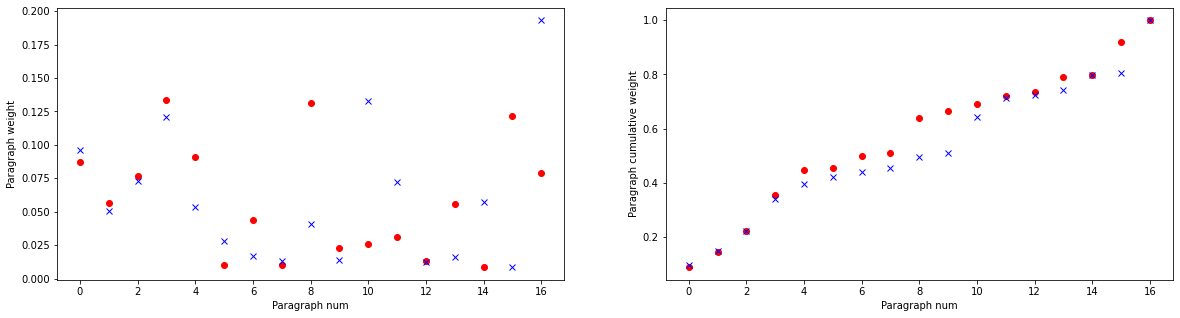

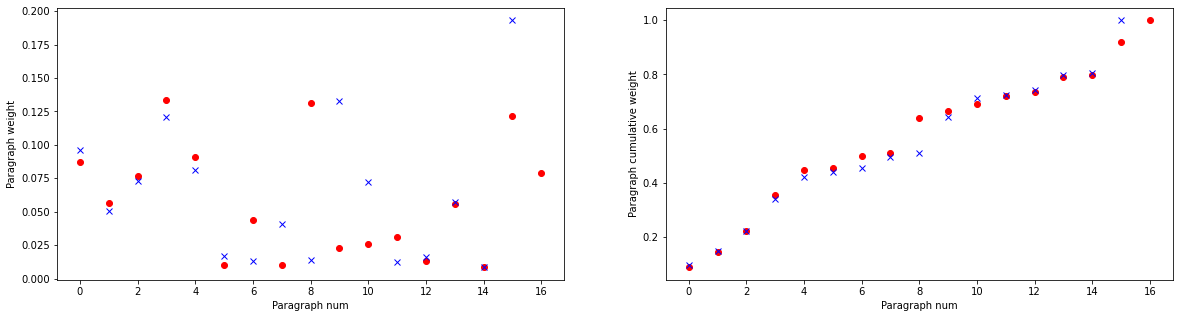

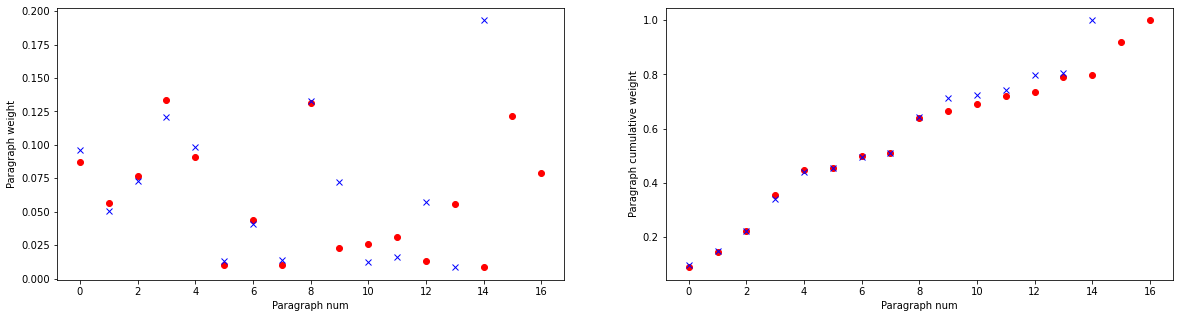

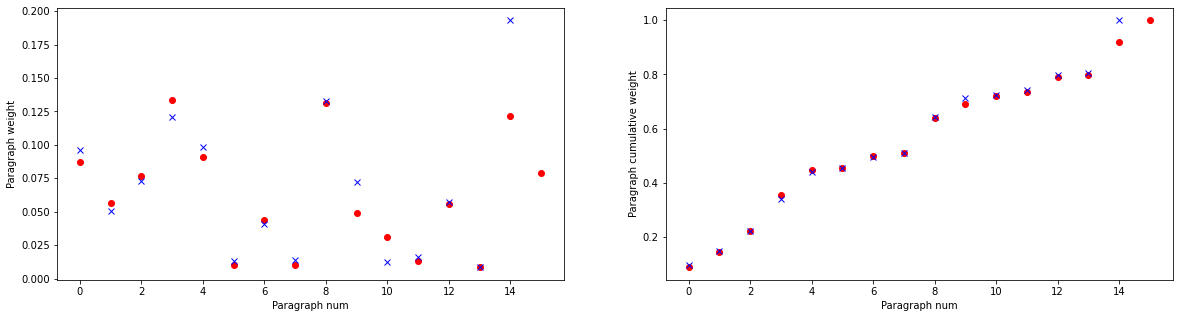

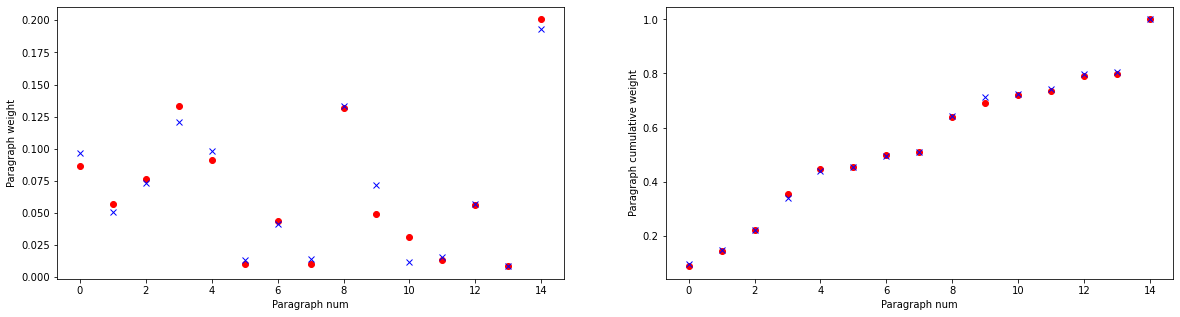

True data:


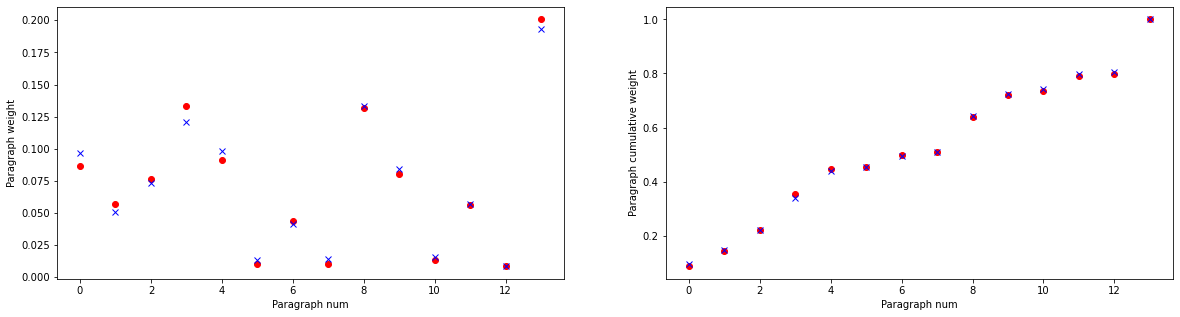

{'merged_source_idx': [10, 16], 'merged_target_idx': [5, 6, 7]}

In [30]:
ChapterResolverZipperLR(raw_data[0]['chapters'][1], scaler, lin_cl).source_target_merge_weights(True)

In [31]:
get_norms(raw_data, ChapterResolverZipperLR, scaler=scaler, clf=lin_cl)

{'accuracy': 0.9685746352413019,
 'precision': 0.6486468955489308,
 'recall': 0.615383037479391,
 'f1': 0.6315767856695871}

Let's get essential data from scaler and classifier, so that we can use them in ruby

In [32]:
scaler.mean_, scaler.scale_

(array([0.18818516, 0.29941137, 0.01186645, 0.80622819, 1.23588856,
        0.02900179]),
 array([0.26094471, 0.34752625, 0.01270093, 0.64622289, 2.29916314,
        0.02497416]))

In [33]:
lin_cl.coef_, lin_cl.intercept_

(array([[ 1.31999696,  0.41629181,  0.80531785, -2.7585228 , -1.07174377,
         -0.92469167]]),
 array([-6.39290198]))